In [1]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import talib
import cvxpy as cp

from fredapi import Fred
from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

# Params

In [2]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 60
threshold = 2_000_000_000
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

In [3]:
# Read in Data
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
fund_q = pd.read_parquet(get_parquet_dir(live) / 'data_fund_raw_q.parquet.brotli')
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')
ret_price = create_return(price, [1])

# Resample to daily
date_index = price.drop(price.columns, axis=1)
fund_q = fund_q.groupby('permno').shift(3)
fund_q = date_index.merge(fund_q, left_index=True, right_index=True, how='left').groupby('permno').ffill()

In [4]:
mom_season_short = PrepFactor(live=live, factor_name='factor_mom_season_short', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season6 = PrepFactor(live=live, factor_name='factor_mom_season6', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_off_season = PrepFactor(live=live, factor_name='factor_mom_off_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
ind_mom = PrepFactor(live=live, factor_name='factor_ind_mom', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()
lag_ret = PrepFactor(live=live, factor_name='factor_ret', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()
volume = PrepFactor(live=live, factor_name='factor_volume', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()
load_ret = PrepFactor(live=live, factor_name='factor_load_ret', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_mom_season_short --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season6 -------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_off_season ----------------------------- | ✔
Shape: (3104852, 1)
Creating factor_ind_mom ------------------------------------ | ✔
Shape: (3104852, 5)
Creating factor_ret ---------------------------------------- | ✔
Shape: (3104852, 5)
Creating factor_volume ------------------------------------- | ✔
Shape: (3104852, 5)
Creating factor_load_ret ----------------------------------- | ✔
Shape: (3105599, 5)


In [5]:
lag_ret = lag_ret[['RET_21', 'RET_126']]
volume = volume[['VOL_21', 'VOL_126']]
ind_mom = ind_mom[['ind_mom_21', 'ind_mom_126']]

# Hedge Portfolio

In [6]:
# Get return data
def get_ret(ticker_list):
    data = get_data_fmp(ticker_list=ticker_list, start=start, current_date=current_date)
    data = data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
    data = data.rename(columns={'Adj Close': 'Close'})
    data = create_return(data, [1])
    data = data.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
    data = data.loc[~data.index.duplicated(keep='first')]
    data = data.fillna(0)
    return data

In [7]:
# Get commodity, real estate, bonds, and metal data
com_ticker = ['NEM', 'GOLD', 'FNV', 'WPM', 'AEM', 'XOM', 'CVX', 'SLB', 'COP', 'STLD', 'AMT', 'CCI', 'PLD', 
              'CTVA', 'SPG', 'EQIX', 'BND', 'AGG', 'BNDX', 'VCIT', 'MUB', 'VCSH', 'BSV', 'VTEB', 'IEF', 'MBB', 
              'GOVT', 'VGSH', 'TIP']
com_port = get_ret(com_ticker)

Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:24<00:00,  1.17ticker/s]


In [8]:
com_port['vol'] = com_port.groupby('ticker')['RET_01'].rolling(60).std().reset_index(level=0, drop=True)
com_port['inv_vol'] = 1 / com_port['vol']
com_port['norm_inv_vol'] = com_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
com_port['weighted_ret'] = com_port['RET_01'] * com_port['norm_inv_vol']
com_port = com_port.groupby('date')['weighted_ret'].sum()
com_port = com_port.to_frame()
com_port.columns = ['comm_ret']

### Macro

In [9]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
interest = fred.get_series("REAINTRATREARAT1YE").to_frame()
interest.columns = ['RIR']
interest = interest.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
interest = interest.reset_index()
interest = pd.merge_asof(date, interest, left_on='date', right_on='index', direction='backward')
interest = interest.set_index('date').drop('index', axis=1)
interest = interest.ffill()

In [10]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
cpi = fred.get_series("CORESTICKM159SFRBATL").to_frame()
cpi.columns = ['CPI']
cpi = cpi.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
cpi = cpi.reset_index()
cpi = pd.merge_asof(date, cpi, left_on='date', right_on='index', direction='backward')
cpi = cpi.set_index('date').drop('index', axis=1)
cpi = cpi.ffill()

In [11]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
yield_curve = fred.get_series("T10Y2Y").to_frame()
yield_curve.columns = ['YIELD']
yield_curve = yield_curve.shift(1)
date = com_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
yield_curve = yield_curve.reset_index()
yield_curve = pd.merge_asof(date, yield_curve, left_on='date', right_on='index', direction='backward')
yield_curve = yield_curve.set_index('date').drop('index', axis=1)
yield_curve = yield_curve.ffill()

In [12]:
macro = pd.concat([interest, cpi, yield_curve], axis=1)

In [13]:
macro['RIR_z'] = (macro['RIR'] - macro['RIR'].mean()) / macro['RIR'].std()
macro['CPI_z'] = (macro['CPI'] - macro['CPI'].mean()) / macro['CPI'].std()
macro['YIELD_z'] = (macro['YIELD'] - macro['YIELD'].mean()) / macro['YIELD'].std()
macro['mt'] = macro[['RIR_z', 'CPI_z', 'YIELD_z']].mean(axis=1)

In [14]:
T = [21, 60]
for t in T:
    macro[f'mt_{t}'] = macro['mt'].rolling(t).mean()

In [15]:
# Macro
macro_buy = (macro['mt_21'] > macro['mt_60'])
macro_buy_df = macro_buy.to_frame('macro_buy')

In [16]:
def calc_macro_port(row, col1, col2):
    if row['macro_buy']:
        return 0.50 * row[col1] + 0.50 * row[col2]
    else:
        return 0.25 * row[col1] + 0.75 * row[col2]

# Get Factor Betas

In [17]:
ret = 'RET_01'
factor_data = (mom_season_short.merge(mom_season6, left_index=True, right_index=True, how='left')
               .merge(load_ret, left_index=True, right_index=True, how='left'))
               # .merge(lag_ret, left_index=True, right_index=True, how='left')
               # .merge(volume, left_index=True, right_index=True, how='left'))

factor_col= factor_data.columns.tolist()
combine = ret_price.merge(factor_data, left_index=True, right_index=True, how='left')

In [18]:
def rolling_ols_mom(data, ret, factor_data, factor_cols, window, name):
    def process_stock(stock_data, ret, factor_data, factor_cols, window, stock_name, index_name):
        model_data = stock_data[[ret] + factor_cols]

        exog = sm.add_constant(model_data[factor_cols])

        rolling_ols = RollingOLS(endog=model_data[ret], exog=exog, window=window)
        factor_model_params = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})

        # Calculate predicted values
        predicted = (exog * factor_model_params).sum(axis=1)
        predicted = predicted.rename('pred')

        # Compute residuals (epsilon)
        epsilon = model_data[ret] - predicted
        epsilon = epsilon.rename('epsil')

        result = factor_model_params.assign(epsil=epsilon, pred=predicted)
        result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
        return result

    tasks = [(group, ret, factor_data, factor_cols, window, stock, data.index.names[0]) for stock, group in data.groupby(data.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(process_stock)(*task) for task in tasks)

    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [19]:
# Execute Rolling LR
beta_data = rolling_ols_mom(data=combine, ret=ret, factor_data=factor_data, factor_cols=factor_col, window=window, name=f'mom_01')

# Strategy

In [20]:
betas = beta_data[beta_data.columns[1:len(factor_col)+2]].reset_index(level=0, drop=True)

In [21]:
# Calculate rolling mean and standard deviation
rolling_mean = betas.groupby('permno')[f'epsil_mom_01_{window:02}'].rolling(window=window).mean().reset_index(level=0, drop=True)
rolling_std = betas.groupby('permno')[f'epsil_mom_01_{window:02}'].rolling(window=window).std().reset_index(level=0, drop=True)
# Calculate the rolling Z-score
betas['s_score'] = (betas[f'epsil_mom_01_{window:02}'] - rolling_mean) / rolling_std
betas = betas.rename(columns={f'epsil_mom_01_{window:02}': 'epsil'})

<AxesSubplot:xlabel='permno,date'>

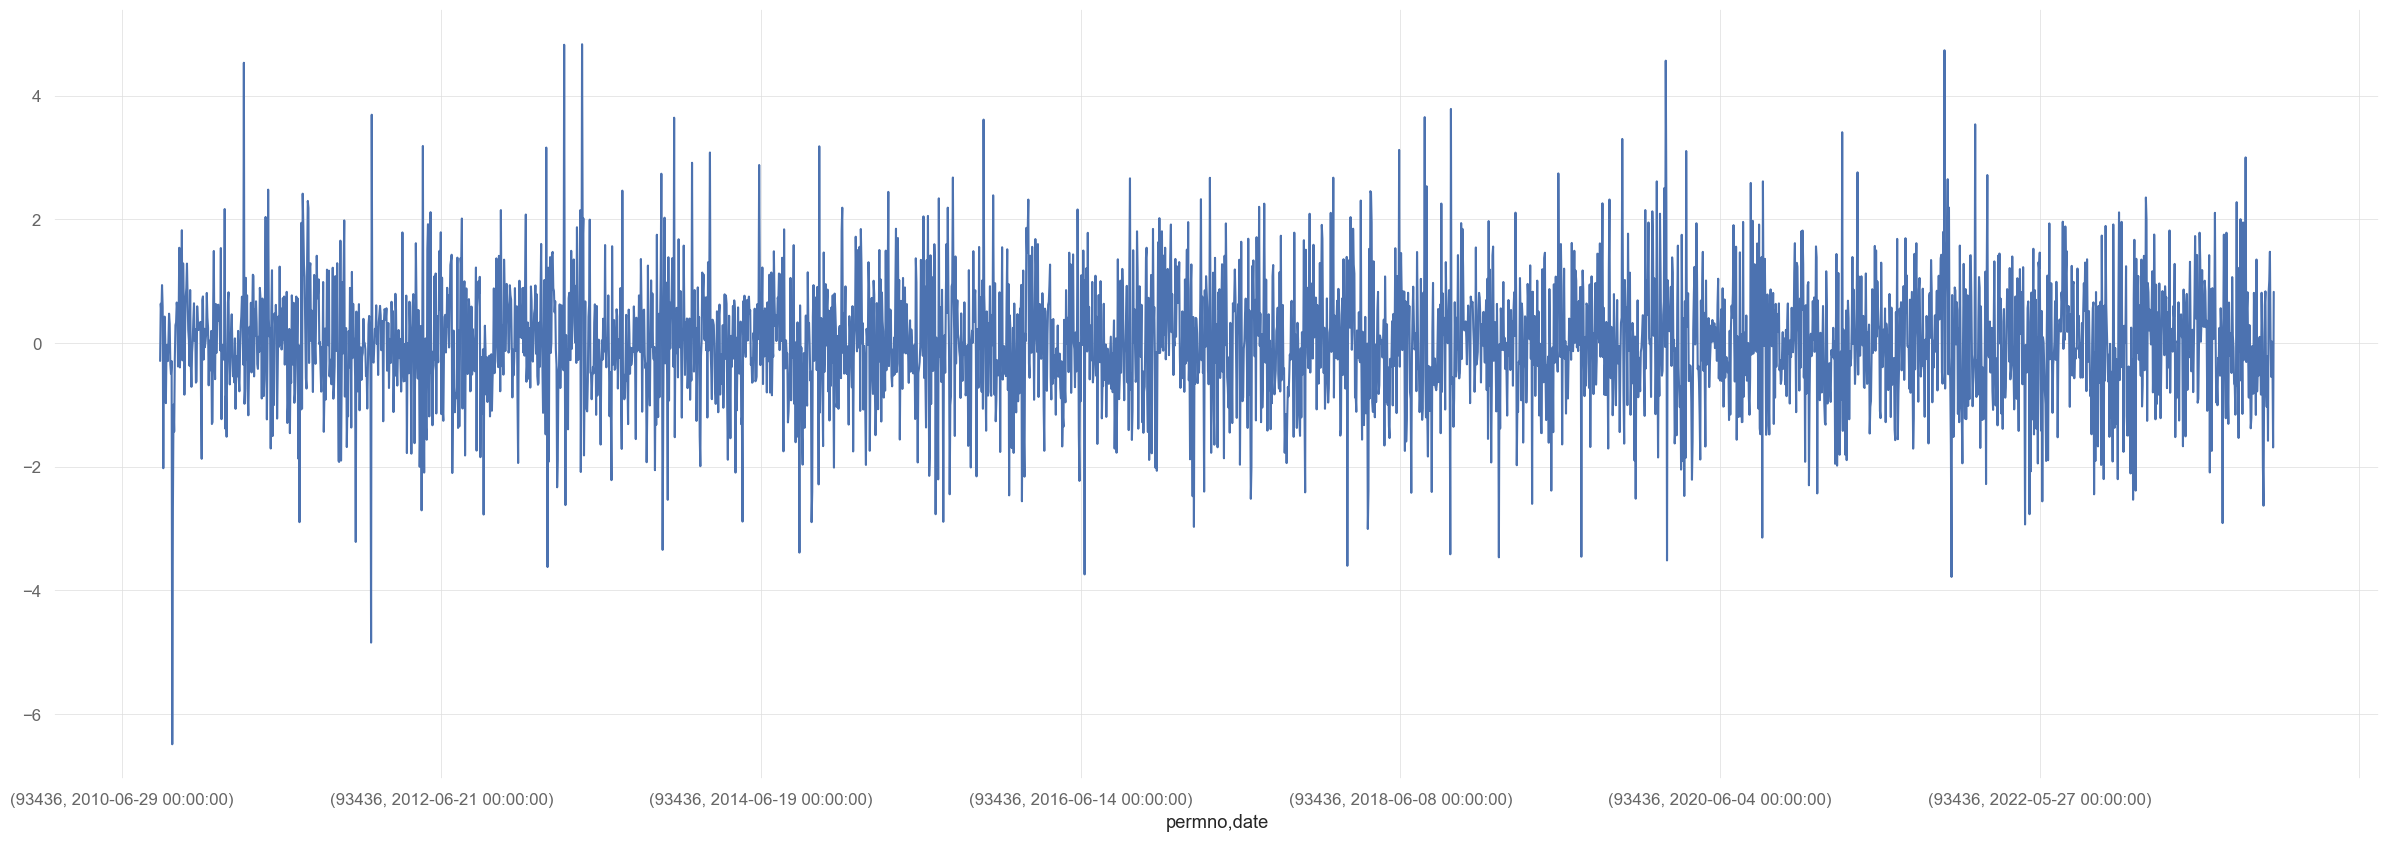

In [22]:
tsla = get_stock_data(betas, 93436)
tsla.s_score.plot(figsize=(30,10))

In [37]:
def create_signal_past(data, sbo, ssc):
    def apply_rules(group):
        # Initialize signals and positions
        signals = [None] * len(group)
        positions = [None] * len(group)
        # Create masks for conditions
        open_long_condition = (group['s_score'] < -sbo)
        close_long_condition = group['s_score'] > -ssc
        # Flag to check if any position is open
        position_open = False
        current_position = None
        
        for i in range(len(group)):
            if position_open:
                if positions[i-1] == 'long' and close_long_condition.iloc[i]:
                    signals[i] = 'close long'
                    positions[i] = None
                    position_open = False
                    current_position = None
                else:
                    signals[i] = 'hold'
                    positions[i] = current_position
            else:
                if open_long_condition.iloc[i]:
                    positions[i] = 'long'
                    signals[i] = 'buy to open'
                    current_position = 'long'
                    position_open = True

        return pd.DataFrame({'signal': signals, 'position': positions}, index=group.index)

    # Sort data
    data = data.sort_index(level=['permno', 'date'])
    # Group by permno and apply the rules for each group
    results = data.groupby('permno').apply(apply_rules).reset_index(level=0, drop=True)
    # Flatten the results and assign back to the data
    data = data.join(results)
    return data

In [38]:
market_cap = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
betas_ret = combine.merge(betas, left_index=True, right_index=True, how='left')
betas_ret = betas_ret.merge(market_cap, left_index=True, right_index=True, how='left')

In [39]:
betas_ret = betas_ret.loc[betas_ret.market_cap > threshold]

In [40]:
sbo = -1.25
ssc = -0.75
betas_ret = create_signal_past(betas_ret, sbo, ssc)

#### TA

In [41]:
T = [5, 21, 60, 126, 252]
for t in T:
    betas_ret[f'ema_{t}'] = (betas_ret.groupby('permno', group_keys=False).apply(lambda x: talib.EMA(x.Close, timeperiod=t)))
for t in T:
    betas_ret[f'rsi_{t}'] = (betas_ret.groupby('permno', group_keys=False).apply(lambda x: talib.RSI(x.Close, timeperiod=t)))

for t in T:
    betas_ret[f'mfi_{t}'] = (betas_ret.groupby('permno', group_keys=False)
                             .apply(lambda x: talib.MFI(x.High, x.Low, x.Close, x.Volume, timeperiod=t)))
for t in T:
    betas_ret[f'cci_{t}'] = (betas_ret.groupby('permno', group_keys=False)
                             .apply(lambda x: talib.CCI(x.High, x.Low, x.Close, timeperiod=t)))

In [42]:
# Signals
mom_buy = (betas_ret['position'] == 'long')
# cumsum_buy = (betas_ret['CUSUM+'] > h)
buy_crossover = (betas_ret['ema_126'] > betas_ret['ema_252'])
rsi_buy = (betas_ret['rsi_5'] < 30)
volume_buy = (betas_ret['Volume'] > betas_ret['Volume'].rolling(window=60).mean())

In [43]:
def select_top(df, top=50):
    filtered_df = df[df['signal'].abs() == 1]
    return filtered_df.nlargest(top, 'inv_vol')

In [44]:
# betas_ret['signal'] = np.where(mom_buy & rsi_buy & buy_crossover & volume_buy, 1, 0)
betas_ret = betas_ret.drop('signal', axis=1)
betas_ret['signal'] = np.where(mom_buy, 1, 0)
betas_ret['vol'] = betas_ret.groupby('permno')['RET_01'].rolling(21).std().reset_index(level=0, drop=True)
betas_ret['inv_vol'] = 1 / betas_ret['vol']
top_betas_ret = betas_ret.groupby('date').apply(select_top).reset_index(level=0, drop=True)

In [45]:
top_betas_ret['adj_weight'] = top_betas_ret['signal'] * top_betas_ret['inv_vol']
top_betas_ret['abs_adj_weight'] = top_betas_ret['adj_weight'].abs()
combined_weights = top_betas_ret.groupby('date')['abs_adj_weight'].sum()
top_betas_ret['normalized_weight'] = top_betas_ret['adj_weight'].div(combined_weights, axis=0)

In [46]:
top_betas_ret['RET_01_shift'] = top_betas_ret.groupby('permno')['RET_01'].shift(-1)
trend_ret = (top_betas_ret['RET_01_shift'] * top_betas_ret['normalized_weight']).groupby('date').sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-04-01   2005-04-01
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          273.52%      -99.74%
CAGR﹪                     5.01%        -19.84%

Sharpe                     0.46         -4.94
Prob. Sharpe Ratio         97.63%       0.0%
Smart Sharpe               0.32         -3.45
Sortino                    0.65         -5.04
Smart Sortino              0.45         -3.52
Sortino/√2                 0.46         -3.56
Smart Sortino/√2           0.32         -2.49
Omega                      0.36         0.36

Max Drawdown               -56.47%      -99.74%
Longest DD Days            1982         6792
Volatility (ann.)          19.5%        6.44%
R^2                        0.03         0.03
Information Ratio          -0.13        -0.13
Calmar      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2005-04-07,2023-11-08,2023-11-10,6792,-99.743925,-99.718964


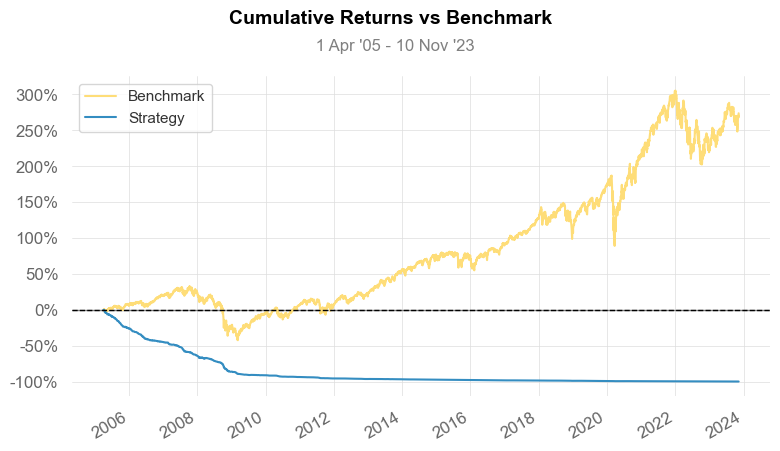

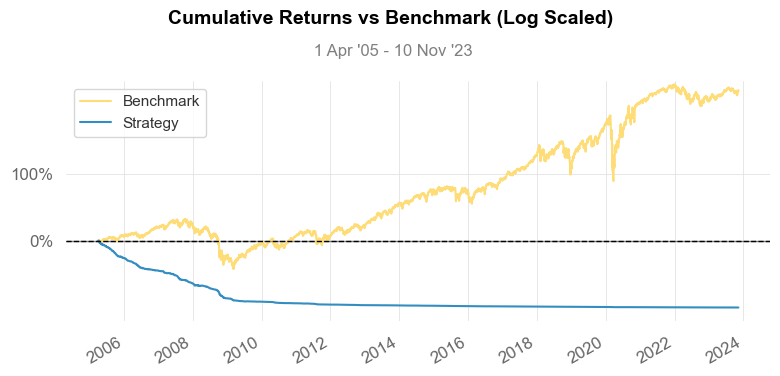

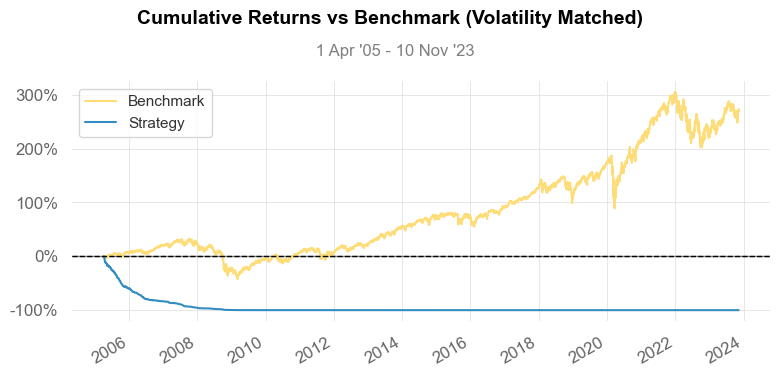

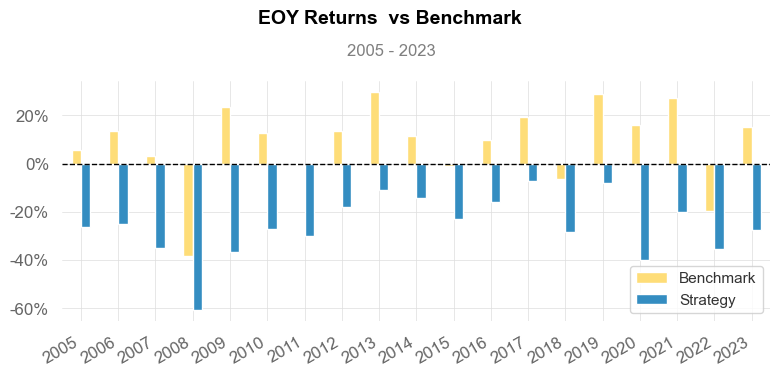

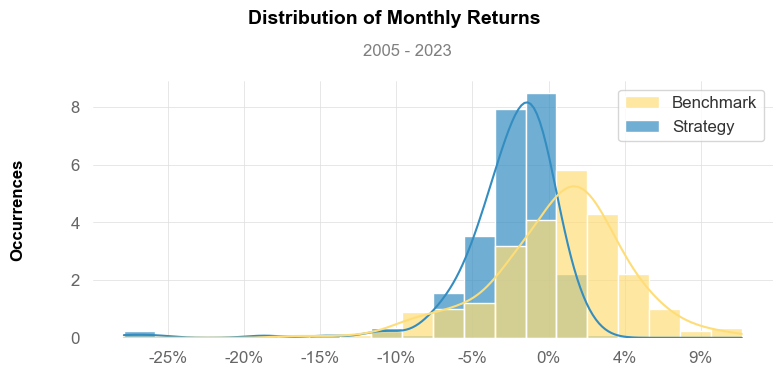

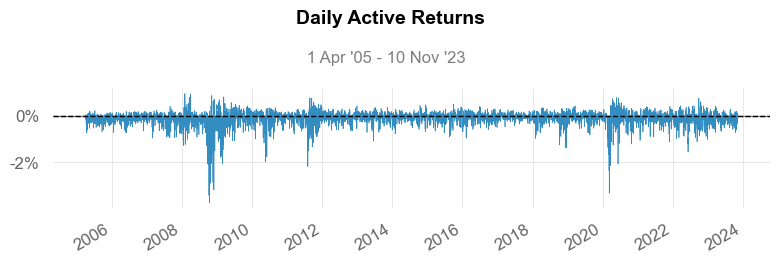

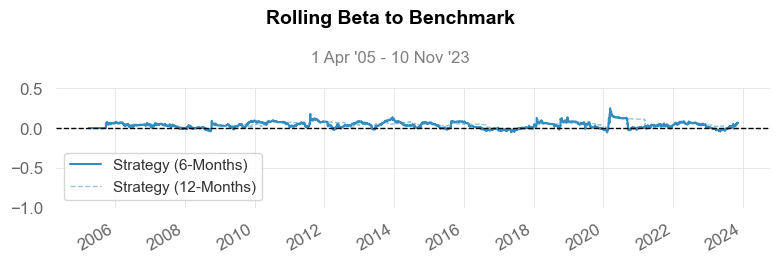

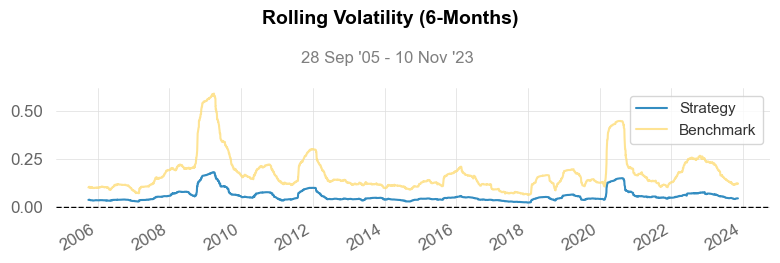

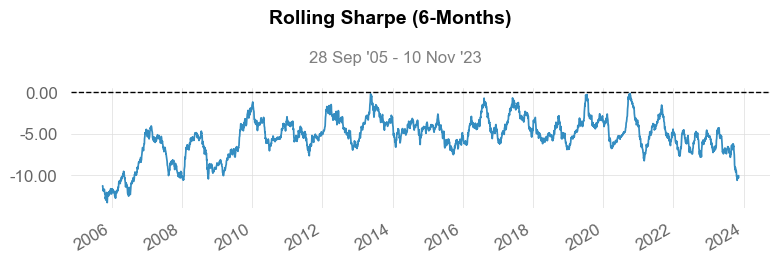

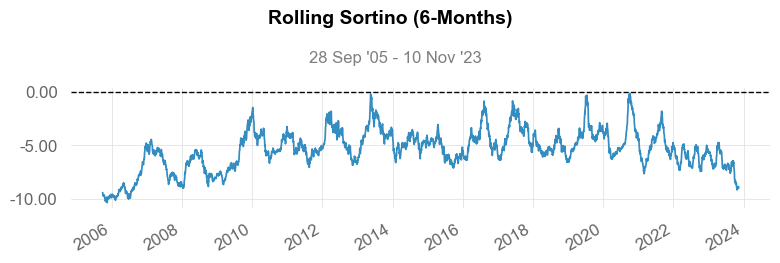

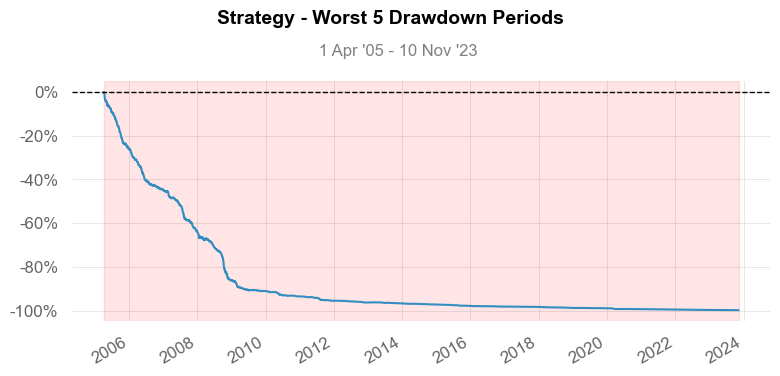

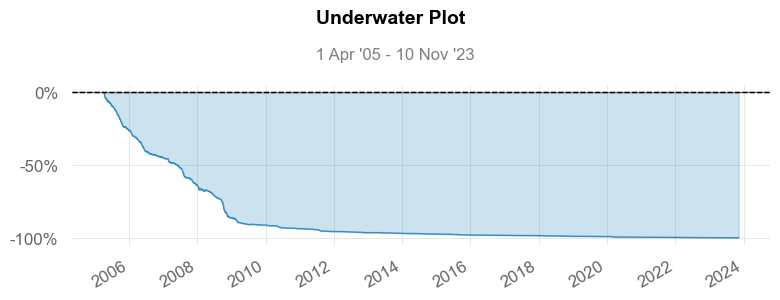

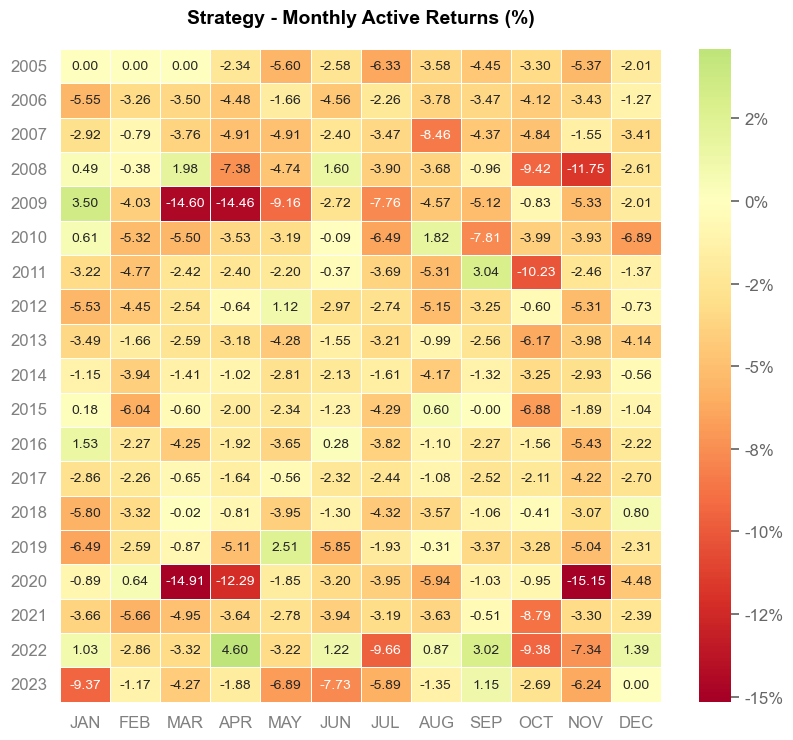

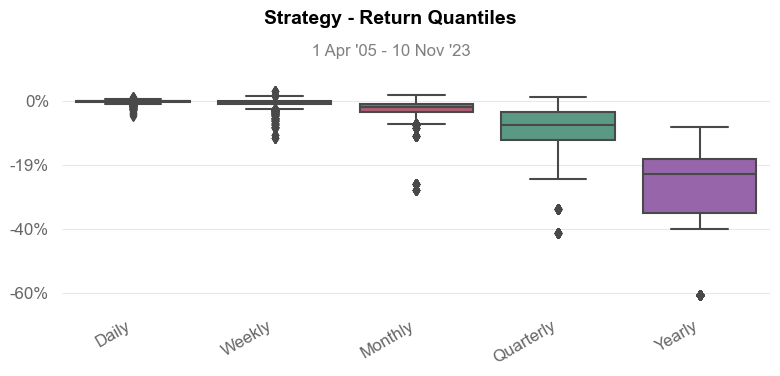

In [47]:
qs.reports.full(trend_ret, 'SPY')

In [34]:
comb_inv_ret = pd.merge(trend_ret.to_frame('trend_ret'), com_port, left_index=True, right_index=True, how='left')
comb_inv_ret = comb_inv_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = comb_inv_ret.columns[0], comb_inv_ret.columns[1]
comb_inv_ret['total_ret'] = comb_inv_ret.apply(calc_macro_port, args=(col1, col2), axis=1)
comb_inv_total = comb_inv_ret['total_ret']

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-04-01   2005-04-01
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          273.52%      -100.0%
CAGR﹪                     5.01%        -100.0%

Sharpe                     0.46         -22.25
Prob. Sharpe Ratio         97.63%       0.0%
Smart Sharpe               0.22         -10.62
Sortino                    0.65         -12.93
Smart Sortino              0.31         -6.17
Sortino/√2                 0.46         -9.14
Smart Sortino/√2           0.22         -4.36
Omega                      0.0          0.0

Max Drawdown               -56.47%      -100.0%
Longest DD Days            1982         6795
Volatility (ann.)          19.53%       10.32%
R^2                        0.0          0.0
Information Ratio          -0.67        -0.67
Calmar    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2005-04-04,2021-11-02,2023-11-10,6795,-100.0,-100.0


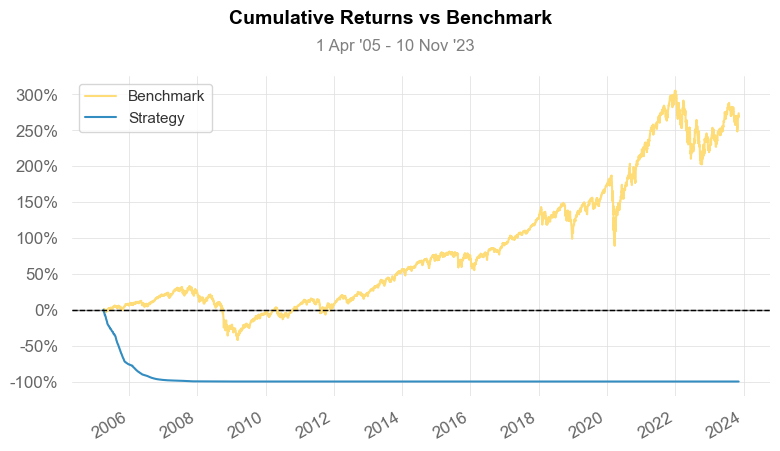

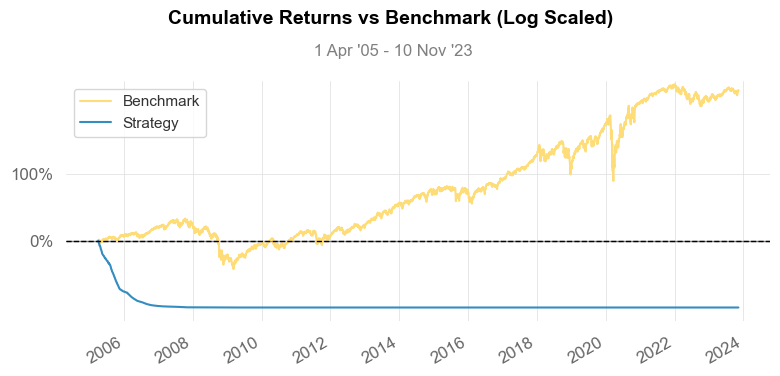

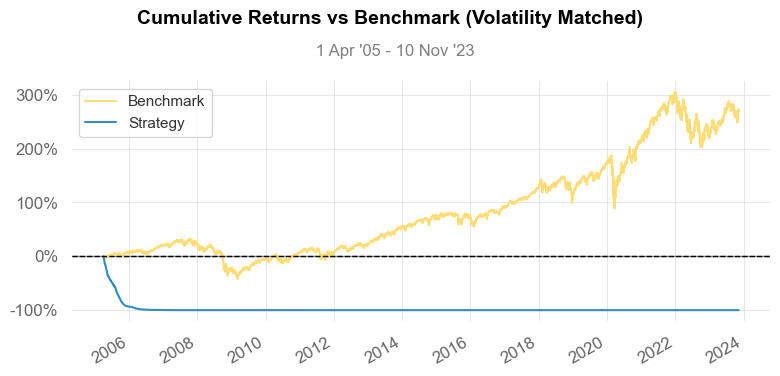

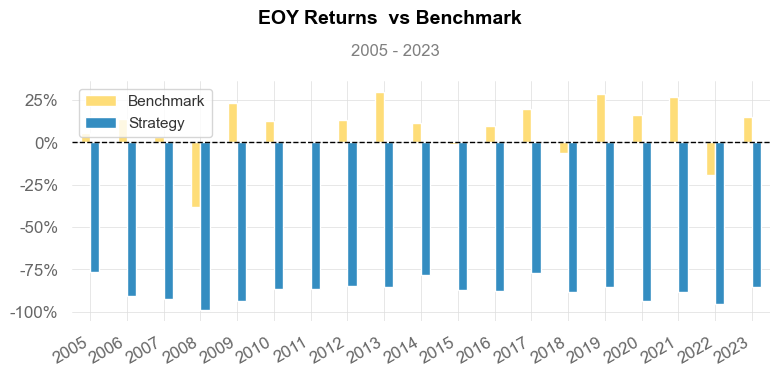

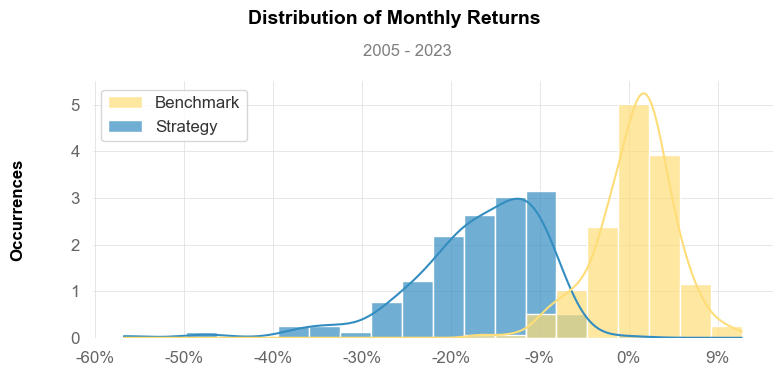

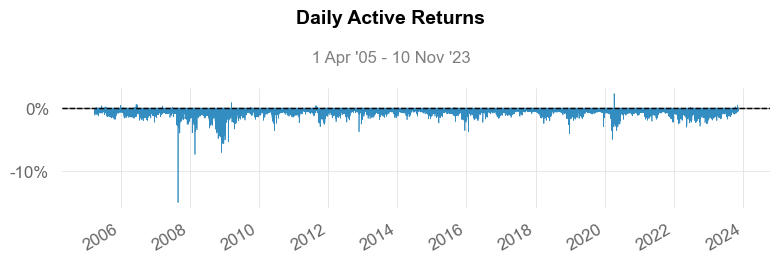

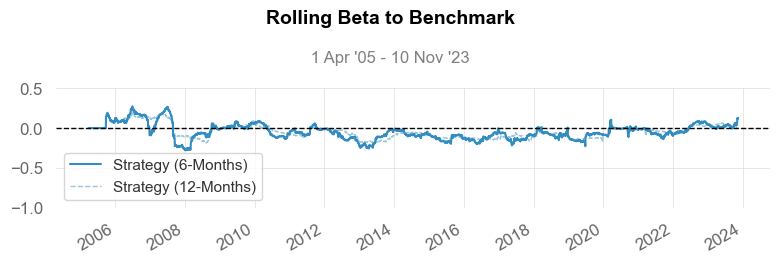

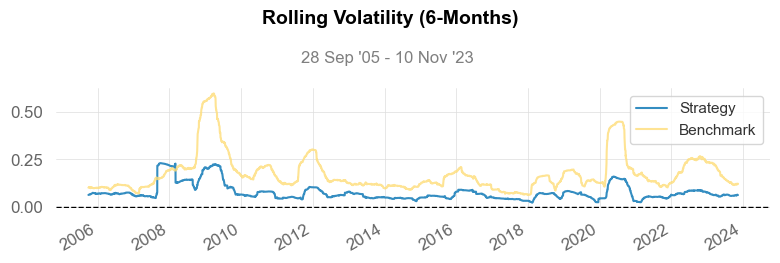

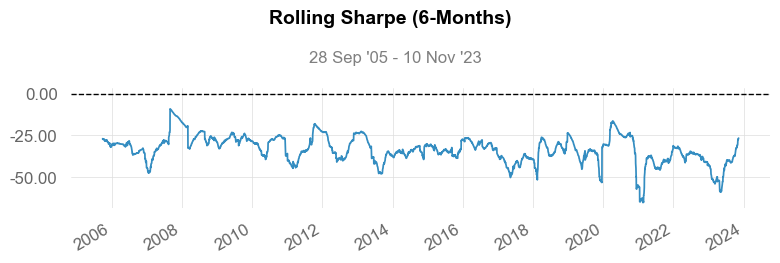

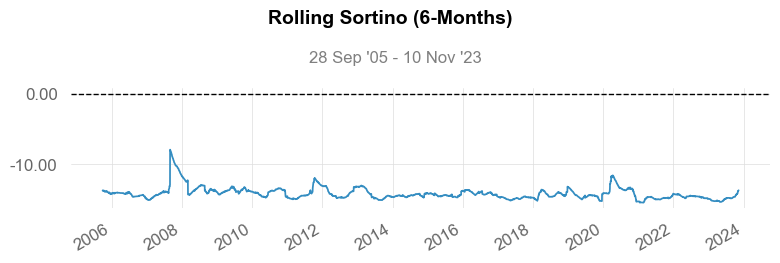

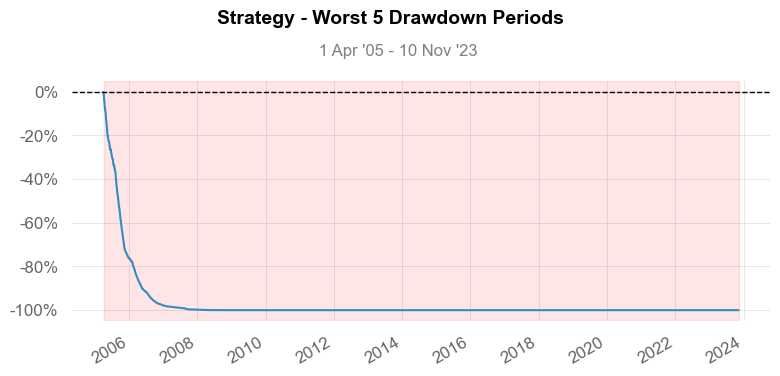

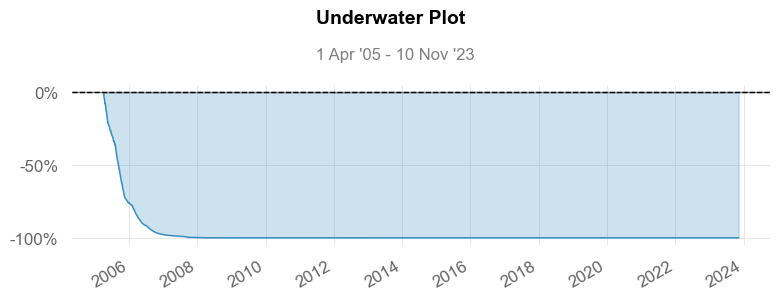

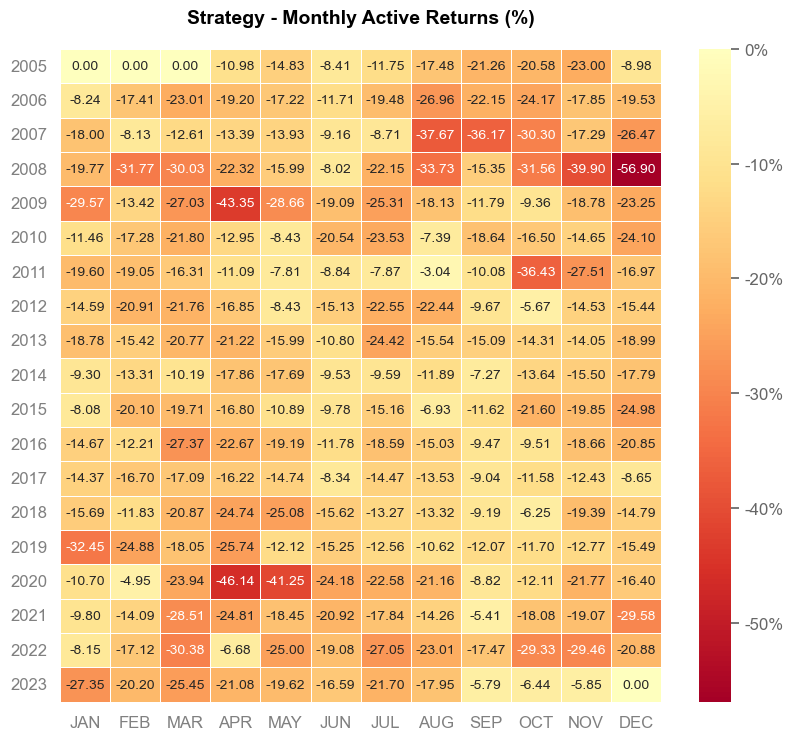

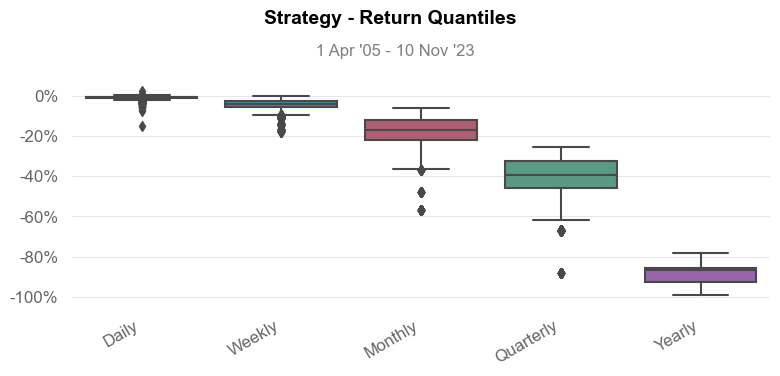

In [35]:
qs.reports.full(comb_inv_total, 'SPY')